# Agent Chat with Multimodal Models

We use **LLaVA** as an example for the multimodal feature.  More information about LLaVA can be found in their [GitHub page](https://github.com/haotian-liu/LLaVA)


This notebook contains the following information and examples:

1. Setup LLaVA Model
    - Option 1: Use [API calls from `Replicate`](#replicate)
    - Option 2: Setup [LLaVA locally (requires GPU)](#local)
2. Application 1: [Image Chat](#app-1)
3. Application 2: [Figure Creator](#app-2)

### Before everything starts, install AutoGen with the `lmm` option
```bash
pip install pyautogen[lmm]
```

In [1]:
# We use this variable to control where you want to host LLaVA, locally or remotely?
# More details in the two setup options below.
LLAVA_MODE = "remote" # Either "local" or "remote"
assert LLAVA_MODE in ["local", "remote"]

In [2]:
import requests
import json
import os

from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

import autogen
from autogen import AssistantAgent, Agent, UserProxyAgent, ConversableAgent
from termcolor import colored
import random

<a id="replicate"></a>
## (Option 1, preferred) Use API Calls from Replicate [Remote]
We can also use [Replicate](https://replicate.com/yorickvp/llava-13b/api) to use LLaVA directly, which will host the model for you.

1. Run `pip install replicate` to install the package
2. You need to get an API key from Replicate from your [account setting page](https://replicate.com/account/api-tokens)
3. Next, copy your API token and authenticate by setting it as an environment variable:
    `export REPLICATE_API_TOKEN=<paste-your-token-here>` 
4. You need to enter your credit card information for Replicate 🥲
    

In [3]:
# pip install replicate
# import os
## alternatively, you can put your API key here for the environment variable.
# os.environ["REPLICATE_API_TOKEN"] = "r8_xyz your api key goes here~"

In [4]:
if LLAVA_MODE == "remote":
    import replicate
    
    llava_config_list = [
        {
            "model": "whatever, will be ignored for remote", # The model name doesn't matter here right now.
            "api_key": "None", # Note that you have to setup the API key with os.environ["REPLICATE_API_TOKEN"] 
            "base_url": "yorickvp/llava-13b:2facb4a474a0462c15041b78b1ad70952ea46b5ec6ad29583c0b29dbd4249591",
        }
    ]

<a id="local"></a>
## [Option 2] Setup LLaVA Locally


## Install the LLaVA library

Please follow the LLaVA GitHub [page](https://github.com/haotian-liu/LLaVA/) to install LLaVA.


#### Download the package
```bash
git clone https://github.com/haotian-liu/LLaVA.git
cd LLaVA
```

#### Install the inference package
```bash
conda create -n llava python=3.10 -y
conda activate llava
pip install --upgrade pip  # enable PEP 660 support
pip install -e .
```



Some helpful packages and dependencies:
```bash
conda install -c nvidia cuda-toolkit
```


### Launch

In one terminal, start the controller first:
```bash
python -m llava.serve.controller --host 0.0.0.0 --port 10000
```


Then, in another terminal, start the worker, which will load the model to the GPU:
```bash
python -m llava.serve.model_worker --host 0.0.0.0 --controller http://localhost:10000 --port 40000 --worker http://localhost:40000 --model-path liuhaotian/llava-v1.5-13b
``

In [5]:
# Run this code block only if you want to run LlaVA locally
if LLAVA_MODE == "local": 
    llava_config_list = [
        {
            "model": "llava-v1.5-13b",
            "api_key": "None",
            "base_url": "http://0.0.0.0:10000",
        }
    ]

# Multimodal Functions

We cal test the `llava_call` function with the following AutoGen image.
![](https://raw.githubusercontent.com/microsoft/autogen/main/website/static/img/autogen_agentchat.png)


In [6]:
from autogen.agentchat.contrib.llava_agent import llava_call

In [7]:
rst = llava_call("Describe this AutoGen framework <img https://raw.githubusercontent.com/microsoft/autogen/main/website/static/img/autogen_agentchat.png> with bullet points.",
          llm_config={
              "config_list": llava_config_list,
              "temperature": 0
          })

print(rst)

The AutoGen framework is a system that enables the creation of flexible conversations between multiple agents. It is designed to optimize the organization and facilitate efficient communication among the agents. The framework consists of several components:

1. Multi-Agent Conversation: This component allows multiple agents to engage in a conversation, exchanging information and collaborating on tasks.
2. Hierarchical Organization: The framework uses a hierarchical organization to structure the conversation, enabling agents to understand and respond to the context of the discussion.
3. Joint Chat: The joint chat feature enables agents to communicate with each other, share information, and collaborate on tasks.
4. Flexible Conversation: The framework supports flexible conversations, allowing agents to adapt to changing situations and respond to new information.
5. Optimization: The AutoGen framework is designed to optimize the organization and communication among agents, ensuring effici

<a id="app-1"></a>
## Application 1: Image Chat

In this section, we present a straightforward dual-agent architecture to enable user to chat with a multimodal agent.


First, we show this image and ask a question.
![](https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0)

Within the user proxy agent, we can decide to activate the human input mode or not (for here, we use human_input_mode="NEVER" for conciseness). This allows you to interact with LLaVA in a multi-round dialogue, enabling you to provide feedback as the conversation unfolds.

In [8]:
from autogen.agentchat.contrib.llava_agent import LLaVAAgent

In [9]:
image_agent = LLaVAAgent(
    name="image-explainer",
    max_consecutive_auto_reply=10,
    llm_config={"config_list": llava_config_list, "temperature": 0.5, "max_new_tokens": 1000}
)

user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="A human admin.",
    code_execution_config={
        "last_n_messages": 3,
        "work_dir": "groupchat"
    },
    human_input_mode="NEVER", # Try between ALWAYS or NEVER
    max_consecutive_auto_reply=0
)

# Ask the question with an image
user_proxy.initiate_chat(image_agent, 
                         message="""What's the breed of this dog? 
<img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.""")

User_proxy (to image-explainer):

What's the breed of this dog? 
<image>.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
You are an AI agent and you can view images.
###Human: What's the breed of this dog? 
<image>.

###Assistant: 
image-explainer (to User_proxy):

The dog in the image is a poodle.

--------------------------------------------------------------------------------


Now, input another image, and ask a followup question.

![](https://th.bing.com/th/id/OIP.29Mi2kJmcHHyQVGe_0NG7QHaEo?pid=ImgDet&rs=1)

In [10]:
# Ask the question with an image
user_proxy.send(message="""What is this breed? 
<img https://th.bing.com/th/id/OIP.29Mi2kJmcHHyQVGe_0NG7QHaEo?pid=ImgDet&rs=1>

Among the breeds, which one barks less?""", 
                recipient=image_agent)

User_proxy (to image-explainer):

What is this breed? 
<image>

Among the breeds, which one barks less?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
You are an AI agent and you can view images.
###Human: What's the breed of this dog? 
<image>.
###Assistant: The dog in the image is a poodle.
###Human: What is this breed? 
<image>

Among the breeds, which one barks less?

###Assistant: 
image-explainer (to User_proxy):

Among the breeds, the Basenji barks less than other breeds.

--------------------------------------------------------------------------------


<a id="app-2"></a>
## Application 2: Figure Creator

Here, we define a `FigureCreator` agent, which contains three child agents: commander, coder, and critics.

- Commander: interacts with users, runs code, and coordinates the flow between the coder and critics.
- Coder: writes code for visualization.
- Critics: LLaVA-based agent that provides comments and feedback on the generated image.

In [11]:
class FigureCreator(AssistantAgent):

    def __init__(self, n_iters=2, **kwargs):
        """
        Initializes a FigureCreator instance.
        
        This agent facilitates the creation of visualizations through a collaborative effort among its child agents: commander, coder, and critics.
        
        Parameters:
            - n_iters (int, optional): The number of "improvement" iterations to run. Defaults to 2.
            - **kwargs: keyword arguments for the parent AssistantAgent.
        """
        super().__init__(**kwargs)
        self.register_reply([Agent, None],
                            reply_func=FigureCreator._reply_user,
                            position=0)
        self._n_iters = n_iters

    def _reply_user(self, messages=None, sender=None, config=None):
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)
            raise AssertionError(error_msg)

        if messages is None:
            messages = self._oai_messages[sender]

        user_question = messages[-1]["content"]

        ### Define the agents
        commander = AssistantAgent(
            name="Commander",
            human_input_mode="NEVER",
            max_consecutive_auto_reply=10,
            system_message=
            "Help me run the code, and tell other agents it is in the <img result.jpg> file location.",
            is_termination_msg=lambda x: x.get("content", "").rstrip().endswith(
                "TERMINATE"),
            code_execution_config={
                "last_n_messages": 3,
                "work_dir": ".",
                "use_docker": False
            },
            llm_config=self.llm_config,
        )

        critics = LLaVAAgent(
            name="Critics",
            system_message=
            """Criticize the input figure. How to replot the figure so it will be better? Find bugs and issues for the figure. 
            Pay attention to the color, format, and presentation. Keep in mind of the reader-friendliness.
            If you think the figures is good enough, then simply say NO_ISSUES""",
            llm_config={"config_list": llava_config_list},
            human_input_mode="NEVER",
            max_consecutive_auto_reply=1,
            #     use_docker=False,
        )

        coder = AssistantAgent(
            name="Coder",
            llm_config=self.llm_config,
        )

        coder.update_system_message(
            coder.system_message +
            "ALWAYS save the figure in `result.jpg` file. Tell other agents it is in the <img result.jpg> file location."
        )

        # Data flow begins
        commander.initiate_chat(coder, message=user_question)
        img = Image.open("result.jpg")
        plt.imshow(img)
        plt.axis('off')  # Hide the axes
        plt.show()
        
        for i in range(self._n_iters):
            commander.send(message="Improve <img result.jpg>",
                           recipient=critics,
                           request_reply=True)
            
            feedback = commander._oai_messages[critics][-1]["content"]
            if feedback.find("NO_ISSUES") >= 0:
                break
            commander.send(
                message="Here is the feedback to your figure. Please improve! Save the result to `result.jpg`\n"
                + feedback,
                recipient=coder,
                request_reply=True)
            img = Image.open("result.jpg")
            plt.imshow(img)
            plt.axis('off')  # Hide the axes
            plt.show()
            
        return True, "result.jpg"

User (to Figure Creator~):


Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.


--------------------------------------------------------------------------------
Commander (to Coder):


Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.


--------------------------------------------------------------------------------
Coder (to Commander):

First, we will download the CSV file, then we will parse it using pandas, a popular data analysis library in Python. After that, we will plot the data using matplotlib.

This is how we could do this:

```python
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the Data
url = "https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv"
data = pd.read_csv(url)

# Step 2: Parse the date to da

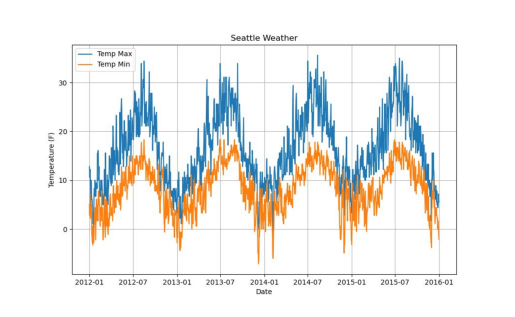

Commander (to Critics):

Improve <image>

--------------------------------------------------------------------------------
Criticize the input figure. How to replot the figure so it will be better? Find bugs and issues for the figure. 
            Pay attention to the color, format, and presentation. Keep in mind of the reader-friendliness.
            If you think the figures is good enough, then simply say NO_ISSUES
###Human: Improve <image>

###Assistant: 
Critics (to Commander):

The input figure is a graph showing the Seattle weather, with a time scale on the bottom. The graph displays a temperature range and a humidity range. The color scheme is predominantly blue, with some orange and yellow colors. 

To improve the figure, one could consider the following:

1. The color scheme could be more consistent, with a more uniform color palette to make it easier to read and understand the data.
2. The labels for the temperature and humidity ranges could be clearer and more prominent, so

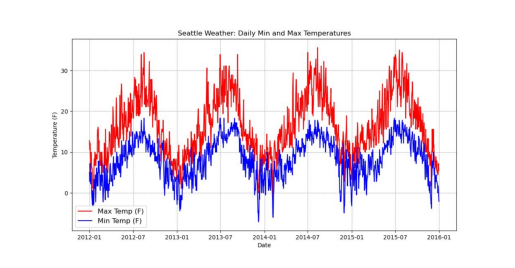

Commander (to Critics):

Improve <image>

--------------------------------------------------------------------------------
Commander (to Coder):

Here is the feedback to your figure. Please improve! Save the result to `result.jpg`
Improve <img result.jpg>

--------------------------------------------------------------------------------
Coder (to Commander):

I apologize for any inconvenience. Could you please provide more specific feedback? What exactly do you want to change or improve on the graph — color scheme, labels, grid, line type, etc.? This would help enhance the figure to better suit your requirements.

--------------------------------------------------------------------------------
Commander (to Coder):

I apologize for the confusion. It seems there was a misunderstanding. You don't need to make any changes to your figure. Please ignore the previous message. Your figure does not need any improvements. The `result.jpg` image is already in the correct file location.

---------

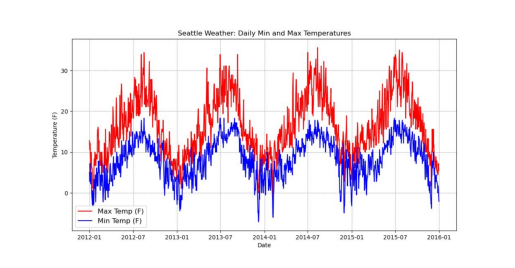

Figure Creator~ (to User):

result.jpg

--------------------------------------------------------------------------------


In [12]:
import matplotlib.pyplot as plt
import time
from PIL import Image

config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

gpt4_llm_config = {"config_list": config_list_gpt4, "seed": 42}

# config_list_gpt35 = autogen.config_list_from_json(
#     "OAI_CONFIG_LIST",
#     filter_dict={
#         "model": ["gpt-35-turbo", "gpt-3.5-turbo"],
#     },
# )

# gpt35_llm_config = {"config_list": config_list_gpt35, "seed": 42}


creator = FigureCreator(
    name="Figure Creator~",
    llm_config=gpt4_llm_config
    
)

user_proxy = autogen.UserProxyAgent(
    name="User",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=0
)

user_proxy.initiate_chat(creator, message="""
Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.
""")


In [13]:
if os.path.exists("result.jpg"):
    os.remove("result.jpg") # clean up